In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
import csv
import unidecode 
import pandas.core.algorithms as algos
from scipy.stats import kendalltau   
from funcoes_uteis import *
from dateutil.relativedelta import relativedelta

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder

from dateutil.relativedelta import relativedelta

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_base = pd.read_csv('./Churn_Consumo_Recomendacao_18.08.2017.csv'
                      , error_bad_lines = False
                      , sep=';'
                      , dtype= {7: str}
                      , encoding='latin-1'
                      , header = None)

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_base.sample(10).T

,6752047,6836742,323600,823629,7882756,710183,248587,138388,6467053,4646037
0,63904214,9060064,684913,4288774,62577792,61858633,7339719,9048194,2604478,62571450
1,__05588044000106__,__04671635000171__,__61287777000173__,__08955672000162__,__09490678000174__,__06155888671__,__00186906021__,__15115126000189__,__28869217850__,__13563652000186__
2,0,0,0,0,0,0,0,0,0,0
3,Anual,Trimestral,NaN,NaN,Anual,Mensal,Semestral,Trimestral,NaN,Trimestral
4,2016-07-25 00:00:00,2015-11-03 00:00:00,2006-10-03 00:00:00,2010-07-24 00:00:00,2015-05-08 00:00:00,2014-07-18 00:00:00,2012-05-23 00:00:00,2015-07-17 00:00:00,2009-05-20 00:00:00,2015-05-07 00:00:00
5,2014-03-18,2008-02-06,2003-01-06,2004-06-16,2015-05-08,2014-07-17,2012-05-23,2009-06-23,2009-05-20,2015-04-27
6,2017-08-03 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2015-03-11 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
7,nao,nao,nao,nao,nao,nao,nao,nao,nao,nao
8,1,1,1,44,1,1,1,1,1,1
9,Hospedagem,Hospedagem,Email,Hospedagem,Hospedagem,Hospedagem,Email,Hospedagem,Email,Email


In [4]:
def diff_month(d1, d2):
    return (d1.year - d2.year)*12 + d1.month - d2.month

def periodicidade(x):
    if x == 'Trienal':
        return 36    
    elif x == 'Anual':
        return 12
    elif x == 'Semestral':
        return 6
    elif x == 'Trimestral':
        return 3
    else: 
        return 1

def marca_lista(lista, tamanho, variavel):
    i = 0
    for i in range(tamanho):
        if variavel == lista[i]: return i
                
def cria_curva(percentiles, variavel):
    Perc = list()
    for i in range(len(percentiles)):
        Perc.append(np.percentile(variavel, percentiles[i]))
    return Perc

def marca_base(Perc, x):
    if x >= Perc[(len(Perc)-1)]:
        return len(Perc) +1
    else:
        for i in range(len(Perc)):
            if x < Perc[i]:
                return i + 1

In [5]:
s = ['Provisioning', 'cd_ChaveCliente', 'nr_PrecoMensal', 'ds_Periodicidade', 'Instalacao', 
     'Primeiro_Servico_LW', 'dt_Reativacao', 'fl_ServicoPai', 'id_GerenteConta', 'Servico', 
     'fl_Dev', 'Perfil', 'classificacao', 'Status', 'Data_Fim', 'Data_Desativacao']

df_base.columns = s

In [ ]:
df_base['Status'] = ['ativo' if s in ['Ativo', 'Atendido', 'Em ativação',
                                      'Aguardando ativação'] else 'inativo'
                     for s in df_base.Status]

df_base = df_base[(df_base.nr_PrecoMensal != '0,00')].copy()
df_base.sort_values(['Instalacao'], ascending= 1 ,inplace=True)
df_base.drop_duplicates(['Provisioning'], keep='last', inplace= True)
col_datas = ['Data_Desativacao', 'Data_Fim', 'Instalacao', 'dt_Reativacao', 'Primeiro_Servico_LW']
converte_datetime(df_base, col_datas)
df_base['Data_Fim_flag'] = [1 if d_fim != datetime(1900,1,1) else 0 for d_fim in df_base.Data_Fim]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_churn'] = df_base[['Data_Fim', 'Data_Desativacao']].min(axis = 1).astype('datetime64[ns]')
df_base['Data_churn'] = [d_fim if ((d_des < d_rea < d_fim) & f_fim & f_des) else d_chu
                              for d_des, d_rea, d_fim, f_fim, f_des, d_chu in 
                              zip(df_base.Data_Desativacao, df_base.dt_Reativacao, 
                                  df_base.Data_Fim, df_base.Data_Fim_flag, 
                                  df_base.Data_Desativacao_flag, df_base.Data_churn)]
df_base['Data_churn_flag'] = [1 if d > datetime(1900, 1, 1) else 0 for d in df_base.Data_churn]

#######################################

df_base = df_base[df_base.Primeiro_Servico_LW >= datetime(1990,1,1)].copy()  #

#######################################


df_base['Primeiro_Servico_LW_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Primeiro_Servico_LW]
df_base['Instalacao_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Instalacao]
df_base['Data_churn_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Data_churn]
df_base['fl_ServicoPai'] = [1 if s in ['SIM', 'Sim', 'sim'] else 0 for s in df_base.fl_ServicoPai]
df_base['fl_GerenteConta'] = [0 if s== 1 else 1 for s in df_base.id_GerenteConta]
df_base['nr_PrecoMensal'] = [x.replace(',', '.') for x in df_base.nr_PrecoMensal]
df_base['nr_PrecoMensal'] = df_base.nr_PrecoMensal.astype(float)
df_base['MesesParaChurn'] = [diff_month(ch, ins) if ch > datetime(1900, 1, 1) else 0
                           for ch, ins in  zip(df_base.Data_churn, df_base.Instalacao)]
df_base['FlagChurn'] = [1 if d!= 0 else 0 for d in df_base.MesesParaChurn]

In [ ]:
def ArrumaBase_Churn(fim_janela_feature, janela_churn, df_base):
    fim_janela_churn = fim_janela_feature+ relativedelta(months=janela_churn)
    inicio_janela_churn = fim_janela_feature
    
    df_treino = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature) & 
                        (df_base.MesesParaChurn == 0) &
                        (df_base.Status == 'ativo')].copy()
    df_treino_fut = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature) & 
                        (df_base.Data_churn > fim_janela_churn)].copy()
    df_treino_fut['FlagChurn'] = 0
    df_treino_churn = df_base[(df_base.Data_churn >= inicio_janela_churn) & 
                              (df_base.Data_churn < fim_janela_churn)].copy()
    df_treino = pd.concat([df_treino, df_treino_churn, df_treino_fut])
    
    agg_dict = {'Provisioning' : 'count'}
    aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
    aux.reset_index(inplace= True)
    aux.rename(columns= {'Provisioning': 'Qtd_Provisioning'}, inplace= True)
    df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')
    
    agg_dict = {'nr_PrecoMensal' : 'sum'}
    aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
    aux.reset_index(inplace= True)
    aux.rename(columns= {'nr_PrecoMensal': 'Valor_cliente_Mes'}, inplace= True)
    df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')
    
    df_treino['Periodicidade_Meses'] = [periodicidade(x) for x in df_treino.ds_Periodicidade]
    df_treino['idade_prov'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Instalacao_AnoMes]
    df_treino['idade_cli'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Primeiro_Servico_LW_AnoMes]
    df_treino['quantidade_renovacoes'] = [int(id_prov/peri_mes) for 
                                          id_prov, peri_mes in zip (df_treino.idade_prov, df_treino.Periodicidade_Meses)]
    df_treino['Qtd_meses_P_renovacoes'] = [peri_mes-(idade_prov-qtd_renov*peri_mes) for
                                           peri_mes,idade_prov,qtd_renov in 
                                           zip(df_treino.Periodicidade_Meses, 
                                               df_treino.idade_prov, 
                                               df_treino.quantidade_renovacoes)]
    df_treino['mes_Proxima_renovacao'] = [datetime((d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).year,
                                                   (d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).month,1) 
                                          for d, qtd_renovacoes, periodicidade, mdelta in 
                                          zip (df_treino.Instalacao_AnoMes, 
                                               df_treino.quantidade_renovacoes,
                                               df_treino.Periodicidade_Meses,
                                               df_treino.Qtd_meses_P_renovacoes)]
    return df_treino

In [ ]:
def CriaRandomForest_Churn(df_treino):
    # shuffle rows
    X = df_treino.sample(frac = 1)
    # create X and y matrices
    y = X.FlagChurn.values
#    Colunas_Modelo = X.reset_index(drop=True).drop(['FlagChurn'], axis = 1).columns
    X = X.reset_index(drop=True).drop(['FlagChurn'], axis = 1).values
    # scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=2)
    auc_list = []
    k = 1
    for train, valid in skf.split(X, y):
        print('Fold #', k)
        print("train indices: %s\nvalidation indices %s" % (train, valid))
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10)
        clf.fit(X[train], y[train])
        y_pred = clf.predict_proba(X[valid])
        auc = roc_auc_score(y[valid], y_pred[:,1])
        auc_list.append(auc)
        print('AUC on fold #', k, ':', auc, '\n')
        k += 1

    print('Average AUC on', k-1, 'folds:', np.mean(auc_list))
    return clf

In [ ]:
def CriaCluster_Churn(clf, df_treino, Colunas_Modelo):

    X = df_treino[Colunas_Modelo].copy()
    X = X.reset_index(drop=True).drop(['FlagChurn'], axis = 1).values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    y_pred = clf.predict_proba(X)
    y_pred = pd.DataFrame(data=y_pred[:,1])
    y_pred.rename(columns= {0: 'Prob_Churn'}, inplace= True)
    
    df_treino = pd.concat([df_treino, y_pred], axis = 1)
    
    percentiles = list()
    inicio = 0
    fim = 100
    salto = 0.25
    aux = round((fim - inicio)/salto)
    for i in range(aux):
        percentiles.append((inicio +i*salto))
    
    Perc = cria_curva(percentiles, df_treino.Prob_Churn)
    df_treino['Prob_Churn_Grupo'] = [marca_base(Perc, x) for x in df_treino.Prob_Churn]
    dict_lista_aux = {'Provisioning' : 'count',
                      'Prob_Churn' : 'min',
                      'FlagChurn' : 'mean'}
    RESUMO = df_treino.groupby('Prob_Churn_Grupo').agg(dict_lista_aux)
    RESUMO.sort_values(['Prob_Churn'], ascending= 0 ,inplace=True)
    RESUMO.Prob_Churn = round(RESUMO.Prob_Churn, ndigits = 2)
    RESUMO['FlagChurn_aux'] = [p*q for p, q in zip (RESUMO.FlagChurn, RESUMO.Provisioning)]
    RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
    RESUMO['Prob_acumulado'] = RESUMO.FlagChurn_aux.cumsum()
    RESUMO['FlagChurn_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
    RESUMO['Prob_Chrun_aux'] = [p*q for p, q in zip (RESUMO.Prob_Churn, RESUMO.Provisioning)]
    RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
    RESUMO['Prob_acumulado'] = RESUMO.Prob_Chrun_aux.cumsum()
    RESUMO['Prob_Chrun_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
    RESUMO.reset_index(inplace= True)
    
    lista = RESUMO.FlagChurn_acumulado
    Prob_aux1 = RESUMO.loc[0].FlagChurn_acumulado
    curva_indice = []
    for i in range(len(lista)):
        Prob_aux2 = lista[i]
        if len(curva_indice) < 9 and Prob_aux1/Prob_aux2 >= 1.25:
            Prob_aux1 = Prob_aux2 
            curva_indice.append(i)
    
    Perc = []
    for i in range(len(curva_indice)):
        Perc.append(RESUMO.FlagChurn_acumulado.loc[curva_indice[i]])
    Perc = Perc[::-1]
    
    RESUMO['Cluster'] = [marca_base(Perc, x) for x in RESUMO.FlagChurn_acumulado]
    RESUMO.reset_index(inplace= True, drop= True)
    
    lista = [RESUMO[RESUMO.Cluster == 1].Prob_Churn_Grupo.max(),
             RESUMO[RESUMO.Cluster == 2].Prob_Churn_Grupo.max(),
             RESUMO[RESUMO.Cluster == 3].Prob_Churn_Grupo.max(),
             RESUMO[RESUMO.Cluster == 4].Prob_Churn_Grupo.max(),
             RESUMO[RESUMO.Cluster == 5].Prob_Churn_Grupo.max(),
             RESUMO[RESUMO.Cluster == 6].Prob_Churn_Grupo.max(),
             RESUMO[RESUMO.Cluster == 7].Prob_Churn_Grupo.max(),
             RESUMO[RESUMO.Cluster == 8].Prob_Churn_Grupo.max(),
             RESUMO[RESUMO.Cluster == 9].Prob_Churn_Grupo.max()]
    
    df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.Prob_Churn_Grupo]
    return df_treino

def ComparaCluster_DadoCli(df_treino):
    aux_Cluster = pd.DataFrame(data=df_treino.Cluster.value_counts()) 
    aux_Cluster.sort_index(inplace= True)
    aux_Cluster['Perc'] = aux_Cluster.Cluster/aux_Cluster.Cluster.sum()
    dict_lista_aux = {'Provisioning' : 'count',
                      'Prob_Churn' : 'min',
                      #'FlagChurn' : 'mean',
                      'nr_PrecoMensal' : 'mean',
                      'fl_ServicoPai' : 'mean',
                      'fl_Dev' : 'mean',
                      'fl_GerenteConta' : 'mean',
                      'Valor_cliente_Mes' : 'mean',
                      'Periodicidade_Meses' : 'mean',
                      'idade_prov' : 'mean',
                      'idade_cli' : 'mean',
                      'quantidade_renovacoes' : 'mean',
                      'Qtd_meses_P_renovacoes' : 'mean'}
    RESUMO = df_treino.groupby('Cluster').agg(dict_lista_aux)
    print(RESUMO)
    return aux_Cluster

def ComparaCluster_FlagChurn(df_treino):
    aux_Cluster = pd.DataFrame(data=df_treino.Cluster.value_counts()) 
    aux_Cluster.sort_index(inplace= True)
    aux_Cluster['Perc'] = aux_Cluster.Cluster/aux_Cluster.Cluster.sum()
    dict_lista = {'FlagChurn' : 'mean'}
    RESUMO = df_treino.groupby('Cluster').agg(dict_lista)
    colunas = RESUMO.drop('FlagChurn', axis = 1).columns
    sns.heatmap(RESUMO, annot=False, linewidths=.5) 
    return RESUMO



def Compara_ClusterProduto_TaxaChurn(df_treino):
    agg_dict_heatmap = {'FlagChurn' : 'mean'}
    heatmap = df_treino.groupby(['Cluster','Servico']).agg(agg_dict_heatmap).copy()
    heatmap.reset_index(inplace= True)
    heatmap = heatmap.pivot('Cluster','Servico', 'FlagChurn').copy()
    heatmap.fillna(0, inplace= True)
    heatmap = heatmap.T
    return heatmap

def Compara_ClusterProduto_QtdProv(df_treino):
    agg_dict_heatmap = {'Provisioning' : 'count'}
    heatmap = df_treino.groupby(['Cluster','Servico']).agg(agg_dict_heatmap).copy()
    heatmap.reset_index(inplace= True)
    heatmap = heatmap.pivot('Cluster','Servico', 'Provisioning').copy()
    heatmap.fillna(0, inplace= True)
    heatmap['TOTAL'] = heatmap[heatmap.columns].sum(axis = 1)    
    heatmap = heatmap.T
    heatmap['TOTAL'] = heatmap[heatmap.columns].sum(axis = 1)
    heatmap.sort('TOTAL', ascending= 0, inplace= True)
    heatmap.drop('TOTAL', axis= 1)
    return heatmap

In [ ]:
def ArrumaBase_Churn_AplicaAlgoritmo(fim_janela_feature, janela_churn, df_base, aux_Cluster, Colunas_Modelo, clf, lista_perfil, lista_classificacao, lista_servico):
    fim_janela_churn = fim_janela_feature+ relativedelta(months=janela_churn)
    inicio_janela_churn = fim_janela_feature
    
    df_treino = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature) & 
                        (df_base.MesesParaChurn == 0) &
                        (df_base.Status == 'ativo')].copy()
    df_treino_fut = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature) & 
                        (df_base.Data_churn > fim_janela_churn)].copy()
    df_treino_fut['FlagChurn'] = 0
    df_treino_churn = df_base[(df_base.Data_churn >= inicio_janela_churn) & 
                              (df_base.Data_churn < fim_janela_churn)].copy()
    df_treino = pd.concat([df_treino, df_treino_churn, df_treino_fut])
    
    agg_dict = {'Provisioning' : 'count'}
    aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
    aux.reset_index(inplace= True)
    aux.rename(columns= {'Provisioning': 'Qtd_Provisioning'}, inplace= True)
    df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')
    
    agg_dict = {'nr_PrecoMensal' : 'sum'}
    aux = df_base[df_base.Instalacao_AnoMes < fim_janela_feature].groupby(['cd_ChaveCliente']).agg(agg_dict).copy()
    aux.reset_index(inplace= True)
    aux.rename(columns= {'nr_PrecoMensal': 'Valor_cliente_Mes'}, inplace= True)
    df_treino = pd.merge(df_treino, aux, on='cd_ChaveCliente')
    
    df_treino['Periodicidade_Meses'] = [periodicidade(x) for x in df_treino.ds_Periodicidade]
    df_treino['idade_prov'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Instalacao_AnoMes]
    df_treino['idade_cli'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Primeiro_Servico_LW_AnoMes]
    df_treino['quantidade_renovacoes'] = [int(id_prov/peri_mes) for 
                                          id_prov, peri_mes in zip (df_treino.idade_prov, df_treino.Periodicidade_Meses)]
    df_treino['Qtd_meses_P_renovacoes'] = [peri_mes-(idade_prov-qtd_renov*peri_mes) for
                                           peri_mes,idade_prov,qtd_renov in 
                                           zip(df_treino.Periodicidade_Meses, 
                                               df_treino.idade_prov, 
                                               df_treino.quantidade_renovacoes)]
    df_treino['mes_Proxima_renovacao'] = [datetime((d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).year,
                                                   (d + timedelta((qtd_renovacoes*periodicidade+mdelta)*365/12)).month,1) 
                                          for d, qtd_renovacoes, periodicidade, mdelta in 
                                          zip (df_treino.Instalacao_AnoMes, 
                                               df_treino.quantidade_renovacoes,
                                               df_treino.Periodicidade_Meses,
                                               df_treino.Qtd_meses_P_renovacoes)]
    
   


    tamanho = len(lista_perfil) 
    df_treino['Perfil_indice'] = [marca_lista(lista_perfil, tamanho, variavel)
                                   for variavel in df_treino.Perfil]
    tamanho = len(lista_classificacao) 
    df_treino['classificacao_indice'] = [marca_lista(lista_classificacao, tamanho, variavel)
                                         for variavel in df_treino.classificacao]
    tamanho = len(lista_servico) 
    df_treino['Servico_indice'] = [marca_lista(lista_servico, tamanho, variavel)
                                   for variavel in df_treino.Servico]
    
    df_treino.fillna(0, inplace= True)
    
    
    
    X = df_treino[Colunas_Modelo].copy()
    X = X.reset_index(drop=True).drop(['FlagChurn'], axis = 1).values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    y_pred = clf.predict_proba(X)
    y_pred = pd.DataFrame(data=y_pred[:,1])
    y_pred.rename(columns= {0: 'Prob_Churn'}, inplace= True)
    
    df_treino = pd.concat([df_treino, y_pred], axis = 1)
    
    
    df_treino.sort_values(['Prob_Churn'], ascending= 1 ,inplace=True)
    df_treino.reset_index(inplace= True, drop= True)
    df_treino.reset_index(inplace= True)
    df_treino.rename(columns= {'index': 'aux_cluster'}, inplace= True)
    
    lista = [round(aux_Cluster[aux_Cluster.index == 1].Perc.max()*df_treino.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 2].Perc.max()*df_treino.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 3].Perc.max()*df_treino.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 4].Perc.max()*df_treino.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 5].Perc.max()*df_treino.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 6].Perc.max()*df_treino.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 7].Perc.max()*df_treino.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 8].Perc.max()*df_treino.aux_cluster.max(),0),
             round(aux_Cluster[aux_Cluster.index == 9].Perc.max()*df_treino.aux_cluster.max(),0)]
    
    
    lista[1] = lista[1] + lista[0]
    lista[2] = lista[2] + lista[1]
    lista[3] = lista[3] + lista[2]
    lista[4] = lista[4] + lista[3]
    lista[5] = lista[5] + lista[4]
    lista[6] = lista[6] + lista[5]
    lista[7] = lista[7] + lista[6]
    lista[8] = lista[8] + lista[7]
    
    df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.aux_cluster]
    
    return df_treino

# 

# 

In [ ]:
df_original = df_base.copy()

# 

In [ ]:
df_base = df_original[df_original.Servico != 'Registro Dominio'].copy()

In [ ]:
df_base.Servico.value_counts()

# 

In [ ]:
fim_janela_feature_1 = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-6)
fim_janela_feature_2 = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-9)
fim_janela_feature_3 = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-12)
fim_janela_feature_4 = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-15)

janela_churn = 3

In [ ]:
result = pd.concat([ArrumaBase_Churn(fim_janela_feature_1, janela_churn, df_base),
                    ArrumaBase_Churn(fim_janela_feature_1, janela_churn, df_base),
                    ArrumaBase_Churn(fim_janela_feature_1, janela_churn, df_base), 
                    ArrumaBase_Churn(fim_janela_feature_2, janela_churn, df_base)], 
                   keys=['base1', 'base2', 'base3', 'base4'])

In [ ]:
lista_perfil = result.Perfil.unique()
tamanho = len(lista_perfil) 
result['Perfil_indice'] = [marca_lista(lista_perfil, tamanho, variavel)
                           for variavel in result.Perfil]

lista_classificacao = result.classificacao.unique()
tamanho = len(lista_classificacao) 
result['classificacao_indice'] = [marca_lista(lista_classificacao, tamanho, variavel)
                                  for variavel in result.classificacao]

lista_servico = result.Servico.unique()
tamanho = len(lista_servico) 
result['Servico_indice'] = [marca_lista(lista_servico, tamanho, variavel)
                            for variavel in result.Servico]

result.fillna(0, inplace= True)

In [ ]:
result.shape

# 

# 

# 

In [ ]:
colunas= ['nr_PrecoMensal', 'fl_ServicoPai',
          'fl_Dev', 'fl_GerenteConta', 'Qtd_Provisioning',
          'Valor_cliente_Mes', 'Periodicidade_Meses', 'idade_prov', 
          'idade_cli', 'quantidade_renovacoes', 'Qtd_meses_P_renovacoes',
          'Perfil_indice', 'classificacao_indice', 'Servico_indice', 'FlagChurn']

clf = CriaRandomForest_Churn(result[colunas])

# 

# 

In [19]:
fim_janela_feature = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-6)
janela_churn = 3

print(fim_janela_feature)
print(fim_janela_feature+ relativedelta(months=janela_churn))

2017-01-01 00:00:00
2017-04-01 00:00:00


# 

# 

In [20]:
#(fim_janela_feature, janela_churn, df_treino, aux_Cluster, colunas, clf, lista_perfil, lista_classificacao, lista_servico)

# 

In [21]:
#flag_dominio = 1

#if flag_dominio == 0:
#    df_treino = df_base[df_base.Servico != 'Registro Dominio'].copy()
#if flag_dominio == 1:
#    df_treino =  df_base[df_base.Servico == 'Registro Dominio'].copy()

In [22]:
df_treino = ArrumaBase_Churn(fim_janela_feature, janela_churn, df_base)

In [23]:
tamanho = len(lista_perfil) 
df_treino['Perfil_indice'] = [marca_lista(lista_perfil, tamanho, variavel)
                              for variavel in df_treino.Perfil]

tamanho = len(lista_classificacao) 
df_treino['classificacao_indice'] = [marca_lista(lista_classificacao, tamanho, variavel)
                                     for variavel in df_treino.classificacao]

tamanho = len(lista_servico) 
df_treino['Servico_indice'] = [marca_lista(lista_servico, tamanho, variavel)
                               for variavel in df_treino.Servico]

df_treino.fillna(0, inplace= True)

In [24]:
df_treino.columns

Index(['Provisioning', 'cd_ChaveCliente', 'nr_PrecoMensal', 'ds_Periodicidade',
       'Instalacao', 'Primeiro_Servico_LW', 'dt_Reativacao', 'fl_ServicoPai',
       'id_GerenteConta', 'Servico', 'fl_Dev', 'Perfil', 'classificacao',
       'Status', 'Data_Fim', 'Data_Desativacao', 'Data_Fim_flag',
       'Data_Desativacao_flag', 'Data_churn', 'Data_churn_flag',
       'Primeiro_Servico_LW_AnoMes', 'Instalacao_AnoMes', 'Data_churn_AnoMes',
       'fl_GerenteConta', 'MesesParaChurn', 'FlagChurn', 'Qtd_Provisioning',
       'Valor_cliente_Mes', 'Periodicidade_Meses', 'idade_prov', 'idade_cli',
       'quantidade_renovacoes', 'Qtd_meses_P_renovacoes',
       'mes_Proxima_renovacao', 'Perfil_indice', 'classificacao_indice',
       'Servico_indice'],
      dtype='object')

In [25]:
df_treino = CriaCluster_Churn(clf, df_treino, colunas)

In [26]:
aux_Cluster = ComparaCluster_DadoCli(df_treino)

         nr_PrecoMensal  quantidade_renovacoes  Valor_cliente_Mes  idade_cli  \
Cluster                                                                        
1             53.708921               3.844731        1207.175150  62.670713   
2             52.928071               1.564709         601.653486  57.258917   
3             51.724558               1.676469         492.051650  56.537290   
4             52.801648               1.207462        1007.852098  87.816101   
5             58.045291               1.519685         846.157968  92.025076   
6             59.011809               1.464857         606.049093  98.088368   
7             57.384753               1.685181         465.970476  71.945692   
8             57.372085               0.967347         261.753008  38.369743   
9             55.670707               0.636114         297.188039  28.532146   
10            59.146350               0.191606         208.164051  12.854015   

         idade_prov  Qtd_meses_P_renova

In [27]:
df_treino.FlagChurn.mean()

0.06671738446438719

,FlagChurn
Cluster,
1,0.001906
2,0.006774
3,0.018884
4,0.042945
5,0.081108
6,0.120775
7,0.154859
8,0.263886
9,0.388792


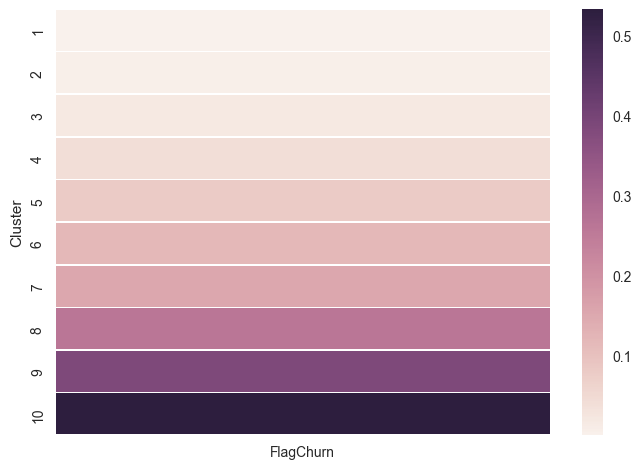

In [28]:
ComparaCluster_FlagChurn = ComparaCluster_FlagChurn(df_treino)
ComparaCluster_FlagChurn

In [29]:
Compara_ClusterProduto_QtdProv = Compara_ClusterProduto_QtdProv(df_treino)
Compara_ClusterProduto_QtdProv

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:122: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cluster,1,2,3,4,5,6,7,8,9,10,TOTAL
Servico,,,,,,,,,,,
Registro Dominio,42507,36757,31456,28222,24486,18638,12153,11270,6906,548,212943
TOTAL,42507,36757,31456,28222,24486,18638,12153,11270,6906,548,212943


In [30]:
Compara_ClusterProduto_TaxaChurn = Compara_ClusterProduto_TaxaChurn(df_treino)
Compara_ClusterProduto_TaxaChurn.round(3)

Cluster,1,2,3,4,5,6,7,8,9,10
Servico,,,,,,,,,,
Registro Dominio,0.002,0.007,0.019,0.043,0.081,0.121,0.155,0.264,0.389,0.535


# 

# 

# Aplicando na Base

In [31]:
df_base.Instalacao_AnoMes.max()

Timestamp('2017-07-01 00:00:00')

In [32]:
print(fim_janela_feature)
print(fim_janela_feature + relativedelta(months=janela_churn))

2017-01-01 00:00:00
2017-04-01 00:00:00


# 

In [33]:
fim_janela_feature = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-3)
janela_churn = 3

In [34]:
print(fim_janela_feature)
print(fim_janela_feature + relativedelta(months=janela_churn))

2017-04-01 00:00:00
2017-07-01 00:00:00


# 

# 

In [35]:
#flag_dominio

#if flag_dominio == 0:
#    df_treino = df_base[df_base.Servico != 'Registro Dominio'].copy()
#if flag_dominio == 1:
#    df_treino =  df_base[df_base.Servico == 'Registro Dominio'].copy()

In [36]:
#df_treino =  df_base.copy()

# 

# 

In [37]:
df_treino = ArrumaBase_Churn_AplicaAlgoritmo(fim_janela_feature, janela_churn, df_base, aux_Cluster, colunas, clf, lista_perfil, lista_classificacao, lista_servico)

In [38]:
aux_Cluster = ComparaCluster_DadoCli(df_treino)

         nr_PrecoMensal  quantidade_renovacoes  Valor_cliente_Mes  idade_cli  \
Cluster                                                                        
1             53.757675               2.984090        1785.525013  79.757785   
2             53.197017               1.904861         633.462646  58.664047   
3             53.131857               1.952663         482.230631  60.398993   
4             53.490842               1.802153         601.954491  66.742756   
5             57.694854               1.722055         637.803555  86.957777   
6             58.556541               1.642903         555.048188  93.718950   
7             57.712219               1.691280         496.618858  78.372890   
8             55.548369               1.308087         242.972947  46.696774   
9             55.244491               0.533026         178.197909  23.573839   
10            53.876503               0.269581         163.853370  14.408015   

         idade_prov  Qtd_meses_P_renova

,FlagChurn
Cluster,
1,0.058556
2,0.067337
3,0.078462
4,0.094124
5,0.150911
6,0.182824
7,0.154811
8,0.086787
9,0.071387


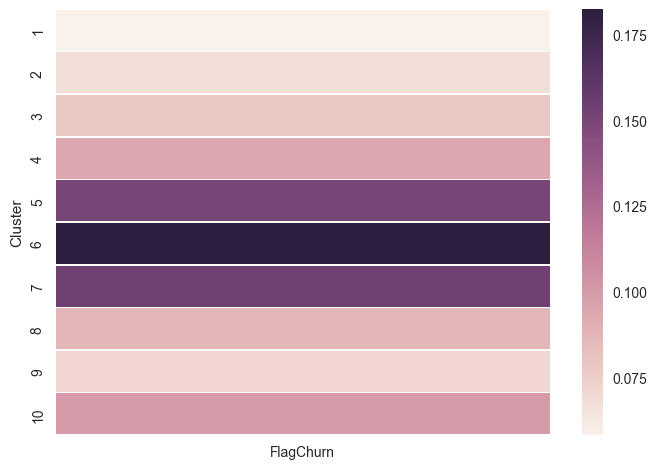

In [41]:
ComparaCluster_FlagChurn = ComparaCluster_FlagChurn(df_treino)
ComparaCluster_FlagChurn

In [42]:
Compara_ClusterProduto_QtdProv = Compara_ClusterProduto_QtdProv(df_treino)
Compara_ClusterProduto_QtdProv

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:122: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Cluster,1,2,3,4,5,6,7,8,9,10,TOTAL
Servico,,,,,,,,,,,
Registro Dominio,42677,36904,31582,28335,24584,18712,12202,11315,6934,549,213794
TOTAL,42677,36904,31582,28335,24584,18712,12202,11315,6934,549,213794


In [43]:
Compara_ClusterProduto_TaxaChurn = Compara_ClusterProduto_TaxaChurn(df_treino)
Compara_ClusterProduto_TaxaChurn.round(3)

Cluster,1,2,3,4,5,6,7,8,9,10
Servico,,,,,,,,,,
Registro Dominio,0.059,0.067,0.078,0.094,0.151,0.183,0.155,0.087,0.071,0.1


In [79]:
Compara_ClusterProduto_TaxaChurn = Compara_ClusterProduto_TaxaChurn(df_treino)
Compara_ClusterProduto_TaxaChurn.round(3)

Cluster,1,2,3,4,5,6,7,8,9,10
Servico,,,,,,,,,,
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Backup de Sites,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Cloud Server Pro,0.040,0.028,0.045,0.061,0.072,0.083,0.088,0.144,0.116,0.326
Cloud VPS,0.062,0.000,0.000,0.167,0.103,0.125,0.106,0.189,0.242,0.465
Criador de Sites,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Descontinuados,0.000,0.000,0.021,0.000,0.000,0.167,0.000,0.000,0.000,0.000
Email,0.006,0.022,0.026,0.044,0.023,0.025,0.000,0.043,0.061,0.000
Email MKT,0.055,0.062,0.066,0.062,0.084,0.097,0.092,0.121,0.142,0.254
Exchange,0.019,0.032,0.035,0.039,0.064,0.032,0.047,0.074,0.029,0.134


In [40]:
Compara_ClusterProduto_TaxaChurn = Compara_ClusterProduto_TaxaChurn(df_treino)
Compara_ClusterProduto_TaxaChurn.round(3)

Cluster,1,2,3,4,5,6,7,8,9,10
Servico,,,,,,,,,,
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Backup de Sites,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Cloud Server Pro,0.043,0.041,0.049,0.062,0.088,0.100,0.137,0.113,0.118,0.340
Cloud VPS,0.091,0.083,0.000,0.140,0.041,0.140,0.180,0.259,0.310,0.489
Criador de Sites,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Descontinuados,0.000,0.005,0.012,0.022,0.111,0.000,0.000,0.000,0.000,0.000
Email,0.005,0.013,0.023,0.019,0.024,0.000,0.065,0.011,0.065,0.200
Email MKT,0.032,0.053,0.072,0.072,0.080,0.101,0.101,0.139,0.135,0.276
Exchange,0.016,0.031,0.031,0.042,0.046,0.056,0.072,0.048,0.034,0.220
